# Saving and Loading Custom Models in PyBaMM

This notebook demonstrates how to create, save, and load custom models in PyBaMM. This notebook demonstrates how to:
1. Create a custom model
2. Save the model to a JSON file
3. Load the model from a JSON file
4. Use the loaded model for simulations
5. Load models from URLs

## Creating a Custom Diffusion Model

PyBaMM provides tutorials that demonstrate how to create different types of custom models.
In this notebook, we will build on one of those examples of creating a [Simple PDE Model.](https://docs.pybamm.org/en/v23.5_a/source/examples/notebooks/creating_models/2-a-pde-model.html)


Here, we implement a simple one-dimensional diffusion model inside a spherical particle, which will serve as the basis for demonstrating how to save and reload custom models.

In [1]:
#
# definig a cuatom model

import os

import matplotlib.pyplot as plt
import numpy as np

import pybamm
from pybamm.expression_tree.operations.serialise import Serialise


class DiffusionModel(pybamm.BaseModel):
    def __init__(self, name="1D Diffusion Model"):
        super().__init__(name)

        # Define variables
        c = pybamm.Variable("Concentration", domain="negative particle")

        # Define flux and PDE
        N = -pybamm.grad(c)  # flux
        dcdt = -pybamm.div(N)  # RHS equation

        # Equations
        self.rhs = {c: dcdt}
        self.initial_conditions = {c: pybamm.Scalar(1)}

        # Boundary conditions
        lbc = pybamm.Scalar(0)
        rbc = pybamm.Scalar(2)
        self.boundary_conditions = {
            c: {"left": (lbc, "Neumann"), "right": (rbc, "Neumann")}
        }

        # Expose variables
        self.variables = {"Concentration": c, "Flux": N}

## Saving and Loading the Model

PyBaMM provides functionality to save custom models to JSON files and load them back.

- `Serialise.save_custom_model()` to save our model to a JSON file
- `Serialise.load_custom_model()` to load it back

In [2]:
# serilaising the model
model = DiffusionModel()

Serialise.save_custom_model(model, "custom_model.json")


# loading the model
loaded_model = Serialise.load_custom_model("custom_model.json")
os.remove("custom_model.json")  # Clean up

## Using the Loaded Model

Once the model has been reloaded, it can be simulated in the same way as the original.  

- Define the geometry and generate the mesh for the simulation.  
- Specify the spatial discretisation methods and apply them to the model.  
- Solve the resulting system of equations.  
- Visualize the results with two plots:  

These results confirm that the loaded model preserves its full functionality and behaves exactly as the original model.


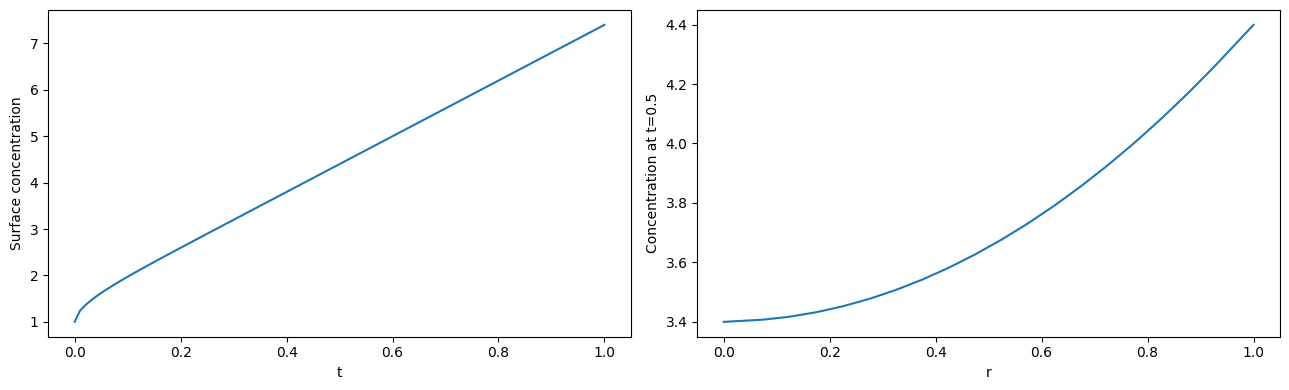

In [3]:
# using loaded_model

r = pybamm.SpatialVariable(
    "r", domain=["negative particle"], coord_sys="spherical polar"
)
geometry = {
    "negative particle": {r: {"min": pybamm.Scalar(0), "max": pybamm.Scalar(1)}}
}


submesh_types = {"negative particle": pybamm.Uniform1DSubMesh}
var_pts = {r: 20}
mesh = pybamm.Mesh(geometry, submesh_types, var_pts)
spatial_methods = {"negative particle": pybamm.FiniteVolume()}
disc = pybamm.Discretisation(mesh, spatial_methods)
disc.process_model(loaded_model)


solver = pybamm.ScipySolver()
t = np.linspace(0, 1, 100)
solution = solver.solve(loaded_model, t)

c = solution["Concentration"]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4))

ax1.plot(solution.t, c(solution.t, r=1))
ax1.set_xlabel("t")
ax1.set_ylabel("Surface concentration")

r_vals = np.linspace(0, 1, 100)
ax2.plot(r_vals, c(t=0.5, r=r_vals))
ax2.set_xlabel("r")
ax2.set_ylabel("Concentration at t=0.5")

plt.tight_layout()
plt.show()

## Loading Models from URLs

PyBaMM also supports loading models directly from remote URLs.  
This functionality is particularly useful for sharing models via GitHub or other hosting platforms.  

In the example below, we demonstrate how to load a Doyle–Fuller–Newman (DFN) model from a GitHub repository and run a simulation.


In [4]:
# loadinng models with urls of json

url = url = (
    "https://raw.githubusercontent.com/medha-14/model_json/refs/heads/main/dfn.json"
)
model = pybamm.Model(url=url)
sim = pybamm.Simulation(model)
sim.solve([0, 3600])
sim.plot(show_plot=False)

TypeError: Model() missing 1 required positional argument: 'model'